In [ ]:


import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, IsolationForest, VotingRegressor
from sklearn.decomposition import PCA

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import shap
import folium
import warnings
warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)
shap.initjs()


In [11]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# ------------------ LOAD DATA ------------------

print("Loading datasets...")
df_day = pd.read_csv("station_day.csv")
df_station = pd.read_csv("stations.csv")

# Verify StationId exists
if 'StationId' not in df_day.columns or 'StationId' not in df_station.columns:
    raise ValueError("Both CSV files must contain 'StationId' column.")

# Merge both datasets
df = pd.merge(df_day, df_station, on='StationId', how='left')
print(f"Merged shape: {df.shape}")

# ------------------ CLEANING STARTS ------------------

# Convert Date column
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).sort_values(by='Date').reset_index(drop=True)

# Remove duplicate entries (same station & date)
df = df.drop_duplicates(subset=['StationId', 'Date'])

# Replace placeholder junk values with NaN
placeholders = ["-", "--", "_", "NaN", "nan", "#N/A", "None", "", " "]
df = df.replace(placeholders, np.nan)

# Convert pollutant columns to numeric
pollutant_cols = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene','AQI']
for col in pollutant_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop columns with more than 40% missing values
df = df.dropna(thresh=int(0.6 * len(df)), axis=1)

# Impute numeric values using median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

# Remove invalid AQI values
if 'AQI' in df.columns:
    df = df[(df['AQI'] > 0) & (df['AQI'] <= 700)]

# Clean City and State columns
for col in ['City', 'State']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Drop rows where City or State is missing
df = df.dropna(subset=['City', 'State'])

# Handle Latitude and Longitude if available
if 'Latitude' in df.columns and 'Longitude' in df.columns:
    df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
    df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
    df.rename(columns={'Latitude': 'lat', 'Longitude': 'lon'}, inplace=True)

print(f"Final cleaned shape: {df.shape}")
print(df.head())


Loading datasets...
Merged shape: (108035, 20)
Final cleaned shape: (107689, 18)
  StationId       Date   PM2.5    PM10     NO    NO2    NOx     CO    SO2  \
0     DL013 2015-01-01  200.96  122.09  17.06  12.39  24.73  21.82   8.91   
1     TN003 2015-01-01   55.95  122.09   6.96  11.08  10.55   1.36   7.62   
2     MH005 2015-01-01   55.95  122.09  10.29  27.21  27.38   0.00   8.95   
3     KA009 2015-01-01   55.95  122.09   2.51  10.79   7.14   1.15   5.08   
4     TN004 2015-01-01   55.95  122.09  33.13  22.56  36.86   0.40  12.36   

      O3  Benzene  Toluene    AQI AQI_Bucket  \
0  30.84     1.21     4.33  364.0  Very Poor   
1  30.84     1.21     4.33  132.0        NaN   
2  30.84     0.00     0.00  132.0        NaN   
3  30.84     1.21     1.15  132.0        NaN   
4  18.85     0.17     4.33  132.0        NaN   

                           StationName       City        State  Status  
0  IHBAS, Dilshad Garden, Delhi - CPCB      Delhi        Delhi  Active  
1               Manal

In [12]:
from sklearn.model_selection import train_test_split

# Features we will use for ML model
numeric_features = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
categorical_features = ['City', 'State']

# Filter dataset to required columns and drop rows with missing data
df_model = df[numeric_features + categorical_features + ['AQI']].dropna()

# Split into input (X) and target (y)
X = df_model[numeric_features + categorical_features]
y = df_model['AQI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train length: {len(y_train)}")
print(f"y_test length: {len(y_test)}")


X_train shape: (86151, 8)
X_test shape: (21538, 8)
y_train length: 86151
y_test length: 21538


In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import sklearn

# Handle OneHotEncoder argument change (sklearn 1.4+ uses sparse_output instead of sparse)
if sklearn.__version__ >= "1.4":
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Preprocessing: scale numeric + one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", ohe, categorical_features)
    ]
)

# Define individual model pipelines
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])

xgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        n_estimators=400, learning_rate=0.08, max_depth=6,
        subsample=0.9, colsample_bytree=0.9,
        random_state=42, verbosity=0
    ))
])

cat_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", CatBoostRegressor(
        depth=8, learning_rate=0.07, iterations=600,
        random_state=42, verbose=0
    ))
])

print("Pipelines successfully created (sklearn version:", sklearn.__version__, ")")


Pipelines successfully created (sklearn version: 1.6.1 )


In [15]:
import time

# Train RandomForest
print("Training RandomForest...")
start = time.time()
rf_pipe.fit(X_train, y_train)
print("RandomForest trained in", round(time.time() - start, 2), "seconds")

# Train XGBoost
print("Training XGBoost...")
start = time.time()
xgb_pipe.fit(X_train, y_train)
print("XGBoost trained in", round(time.time() - start, 2), "seconds")

# Train CatBoost
print("Training CatBoost...")
start = time.time()
cat_pipe.fit(X_train, y_train)
print("CatBoost trained in", round(time.time() - start, 2), "seconds")

# Voting model using the fitted pipelines
vote_pipe = VotingRegressor([
    ('rf', rf_pipe),
    ('xgb', xgb_pipe),
    ('cat', cat_pipe)
])

print("Training Voting Regressor...")
start = time.time()
vote_pipe.fit(X_train, y_train)
print("Voting Regressor trained in", round(time.time() - start, 2), "seconds")

print("All models successfully trained.")


Training RandomForest...
RandomForest trained in 59.38 seconds
Training XGBoost...
XGBoost trained in 2.3 seconds
Training CatBoost...
CatBoost trained in 5.4 seconds
Training Voting Regressor...
Voting Regressor trained in 98.09 seconds
All models successfully trained.


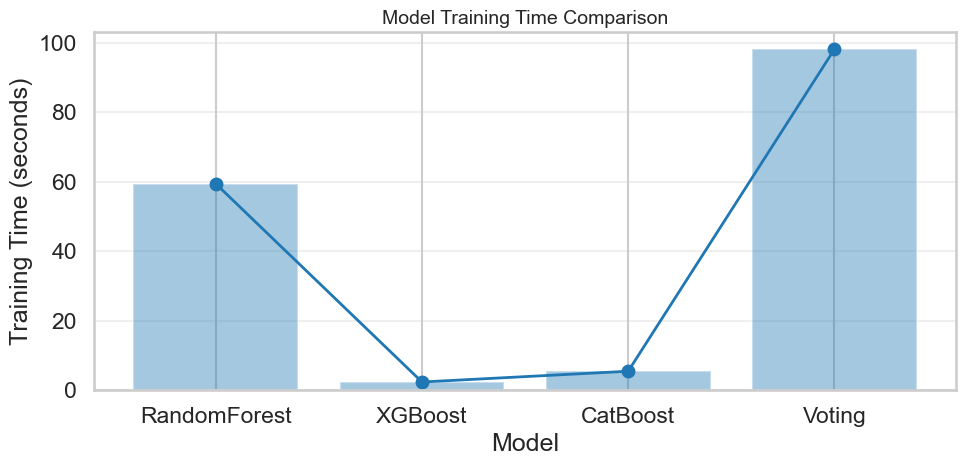

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# Example dictionary (replace with your real values)
train_times = {
    "RandomForest": 59.38,
    "XGBoost": 2.30,
    "CatBoost": 5.40,
    "Voting": 98.09
}

df_time = pd.DataFrame(list(train_times.items()), columns=["Model", "Train_Time_sec"])

plt.figure(figsize=(10,5))
plt.plot(df_time["Model"], df_time["Train_Time_sec"], marker='o', linewidth=2)
plt.bar(df_time["Model"], df_time["Train_Time_sec"], alpha=0.4)

plt.title("Model Training Time Comparison", fontsize=14)
plt.xlabel("Model")
plt.ylabel("Training Time (seconds)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

def evaluate_model(pipe, X_te, y_te, name):
    y_pred = pipe.predict(X_te)
    r2 = r2_score(y_te, y_pred)
    mae = mean_absolute_error(y_te, y_pred)

    # Compute RMSE safely for all sklearn versions
    mse = mean_squared_error(y_te, y_pred)
    rmse = np.sqrt(mse)

    print(f"{name}: R2={r2:.4f} | MAE={mae:.2f} | RMSE={rmse:.2f}")
    return {"R2": r2, "MAE": mae, "RMSE": rmse}

# Run evaluation
metrics = {}
metrics["RandomForest"] = evaluate_model(rf_pipe,  X_test, y_test, "RandomForest")
metrics["XGBoost"]      = evaluate_model(xgb_pipe, X_test, y_test, "XGBoost")
metrics["CatBoost"]     = evaluate_model(cat_pipe, X_test, y_test, "CatBoost")
metrics["Voting"]       = evaluate_model(vote_pipe, X_test, y_test, "Voting")

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics).T
print("\nModel Performance Summary:")
print(metrics_df)


RandomForest: R2=0.8947 | MAE=19.36 | RMSE=35.83
XGBoost: R2=0.8992 | MAE=19.43 | RMSE=35.06
CatBoost: R2=0.9008 | MAE=19.49 | RMSE=34.78
Voting: R2=0.9015 | MAE=19.04 | RMSE=34.66

Model Performance Summary:
                    R2        MAE       RMSE
RandomForest  0.894722  19.362329  35.831571
XGBoost       0.899188  19.431225  35.063190
CatBoost      0.900832  19.487175  34.776127
Voting        0.901508  19.039882  34.657405


In [19]:
import joblib, os

os.makedirs("models", exist_ok=True)

models_bundle = {
    "rf": rf_pipe,
    "xgb": xgb_pipe,
    "cat": cat_pipe,
    "vote": vote_pipe,
    "feature_lists": {
        "numeric_features": numeric_features,
        "categorical_features": categorical_features
    }
}

joblib.dump(models_bundle, "models/models_bundle.joblib")
print("Saved models_bundle.joblib containing: rf, xgb, cat, vote models.")


Saved models_bundle.joblib containing: rf, xgb, cat, vote models.


In [20]:
import os
os.listdir("models")


['lightgbm_aqi_model.joblib',
 '.DS_Store',
 'features.json',
 'st_transformer_aqi_tf.keras',
 'xgb_model.joblib',
 'extra_trees_aqi.pkl',
 'best_model.joblib',
 'stack_aqi_model.joblib',
 'scaler.joblib',
 'rf_model.joblib',
 'models_bundle.joblib',
 'ngboost_aqi_model.joblib',
 'label_encoders.joblib',
 'cat_model.joblib',
 'vote_model.joblib',
 'catboost_aqi_model.cbm']

Running PCA projection...


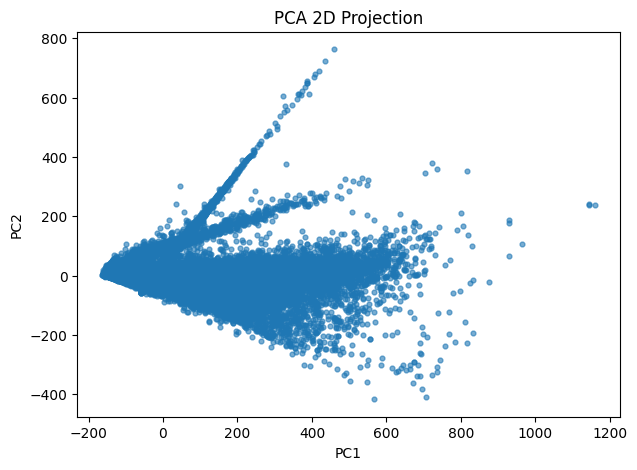

Explained variance: [0.76648132 0.11942584]


In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print("Running PCA projection...")

pca = PCA(n_components=2)
numeric_df = df[numeric_features].fillna(0)
pca_result = pca.fit_transform(numeric_df)

plt.figure(figsize=(7,5))
plt.scatter(pca_result[:,0], pca_result[:,1], s=12, alpha=0.6)
plt.title("PCA 2D Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Explained variance:", pca.explained_variance_ratio_)


In [29]:
from sklearn.ensemble import IsolationForest

print("Running anomaly detection...")

iso = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = (iso.fit_predict(df[['AQI']]) == -1).astype(int)

print("Anomalies detected:", df['anomaly'].sum())

df[df['anomaly'] == 1].head()


Running anomaly detection...
Anomalies detected: 1070


,StationId,Date,PM2.5,PM10,NO,NO2,NOx,CO,SO2,O3,Benzene,Toluene,AQI,AQI_Bucket,StationName,City,State,Status,anomaly
9,DL007,2015-01-01,425.49,607.98,49.37,40.91,90.29,0.69,8.95,143.84,9.19,14.16,579.0,Severe,"CRRI Mathura Road, Delhi - IMD",Delhi,Delhi,Active,1
530,GJ001,2015-02-03,139.70,122.09,30.61,28.40,56.73,30.61,33.79,73.60,0.17,0.03,660.0,Severe,"Maninagar, Ahmedabad - GPCB",Ahmedabad,Gujarat,Active,1
735,GJ001,2015-02-16,99.70,122.09,19.85,28.10,47.31,19.85,73.23,30.57,10.28,31.25,536.0,Severe,"Maninagar, Ahmedabad - GPCB",Ahmedabad,Gujarat,Active,1
775,GJ001,2015-02-18,100.79,122.09,16.24,25.93,41.91,16.24,43.11,37.43,10.00,32.41,592.0,Severe,"Maninagar, Ahmedabad - GPCB",Ahmedabad,Gujarat,Active,1
806,GJ001,2015-02-20,140.29,122.09,33.84,36.14,68.85,33.84,101.53,40.98,20.12,43.51,588.0,Severe,"Maninagar, Ahmedabad - GPCB",Ahmedabad,Gujarat,Active,1



 VISUALIZATION SECTION



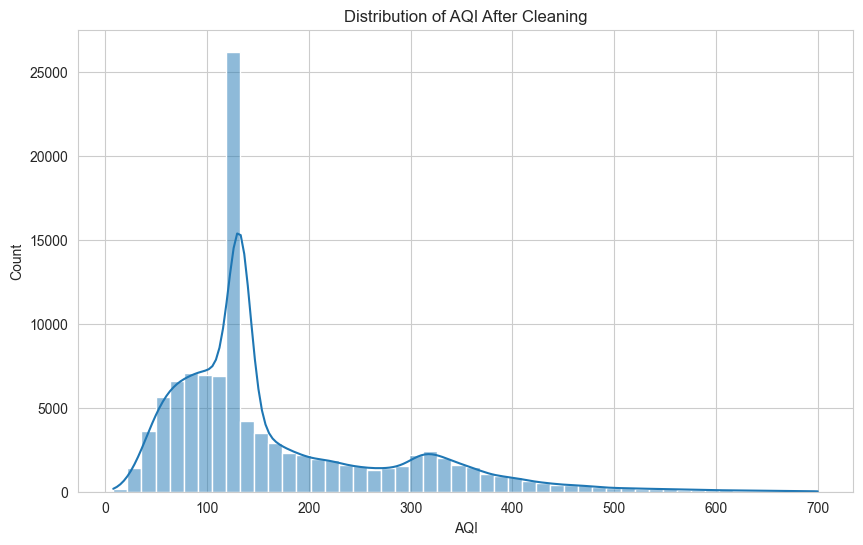

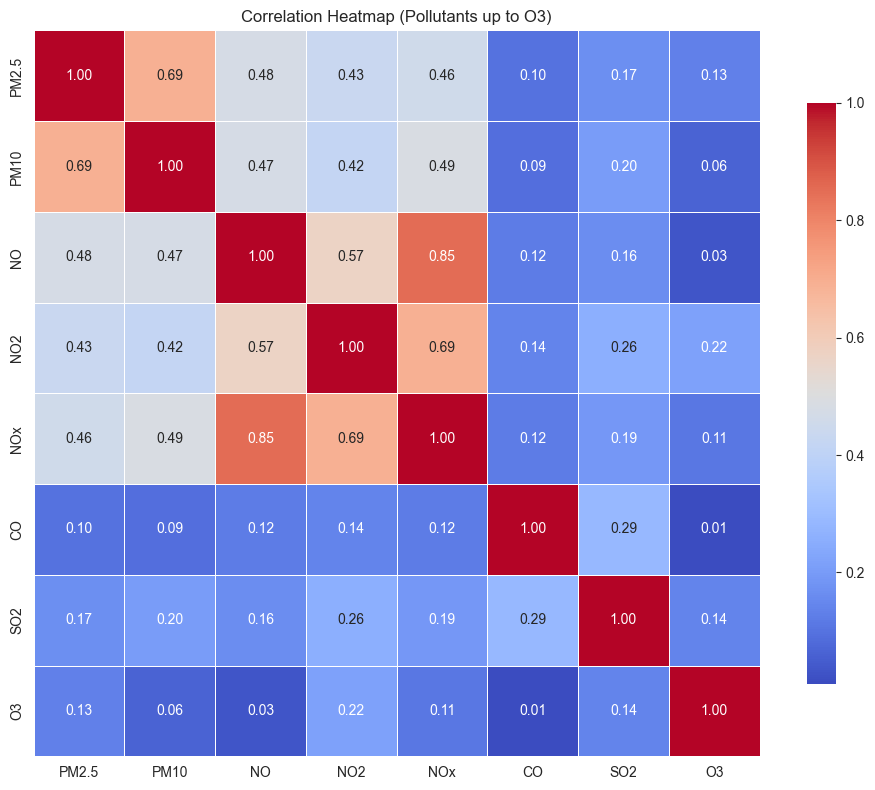

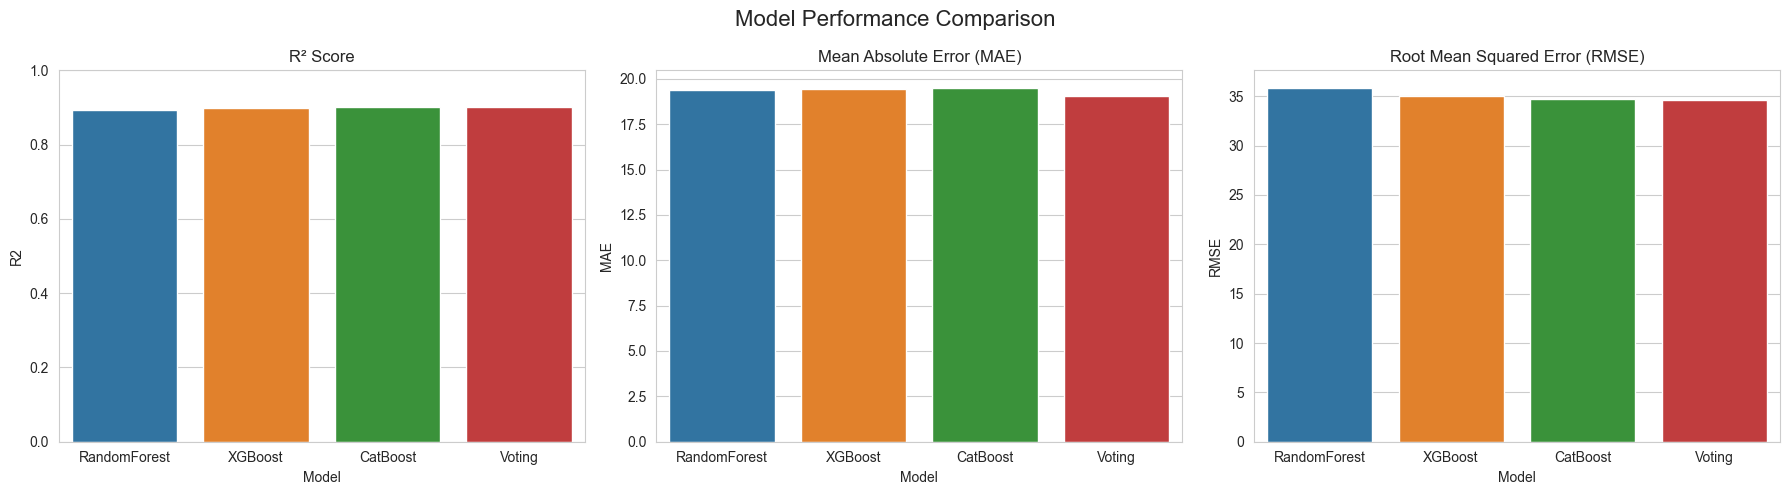

Training time not recorded, skipping training time plot.

(SHAP for Voting model skipped — using CatBoost SHAP separately)



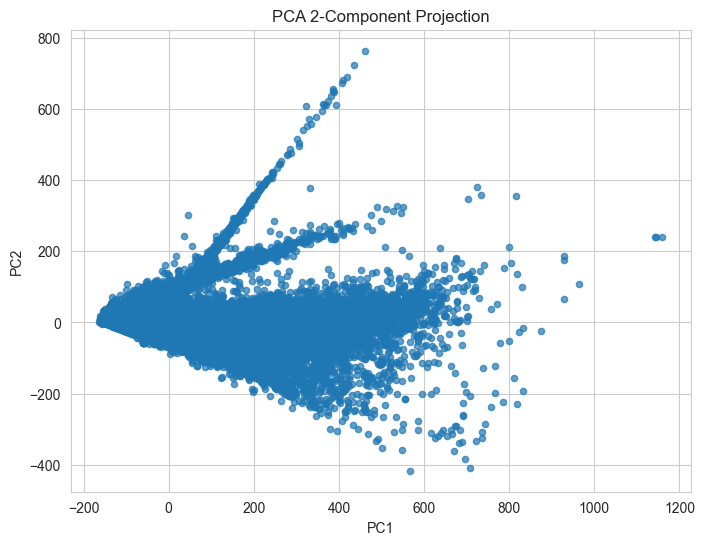

Explained variance ratios: [0.76648132 0.11942584]


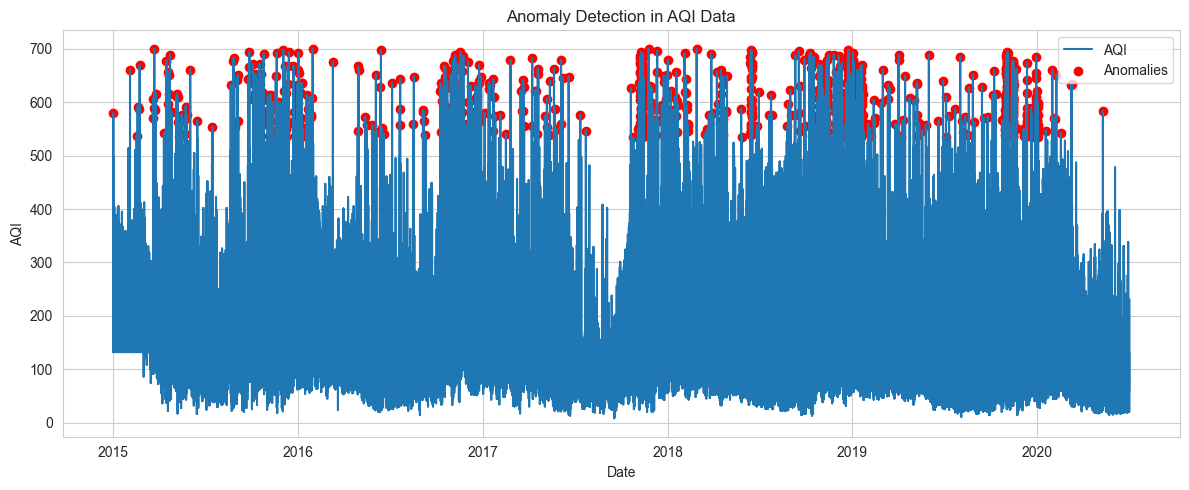


Core visualizations completed.



In [ ]:

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

sns.set_style("whitegrid")

print("\n VISUALIZATION SECTION\n")


plt.figure(figsize=(10, 6))
sns.histplot(df['AQI'], bins=50, kde=True)
plt.title("Distribution of AQI After Cleaning")
plt.xlabel("AQI")
plt.ylabel("Count")
plt.show()


pollutants_upto_o3 = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']
cols = [c for c in pollutants_upto_o3 if c in df.columns]

if len(cols) > 1:
    df_corr = df[cols].apply(pd.to_numeric, errors='coerce').corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_corr, cmap='coolwarm', annot=True, fmt=".2f",
                square=True, cbar_kws={'shrink': 0.8},
                linewidths=0.5, linecolor='white')
    plt.title("Correlation Heatmap (Pollutants up to O3)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough pollutant columns for heatmap.")




results_df = pd.DataFrame(metrics).T.reset_index().rename(columns={'index': 'Model'})


if "Train_Time_sec" not in results_df.columns:
    results_df["Train_Time_sec"] = np.nan

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(ax=axes[0], data=results_df, x='Model', y='R2', hue='Model', legend=False)
axes[0].set_title('R² Score')
axes[0].set_ylim(0, 1)

sns.barplot(ax=axes[1], data=results_df, x='Model', y='MAE', hue='Model', legend=False)
axes[1].set_title('Mean Absolute Error (MAE)')

sns.barplot(ax=axes[2], data=results_df, x='Model', y='RMSE', hue='Model', legend=False)
axes[2].set_title('Root Mean Squared Error (RMSE)')

plt.suptitle("Model Performance Comparison", fontsize=16)
plt.tight_layout()
plt.show()


if not results_df['Train_Time_sec'].isna().all():
    plt.figure(figsize=(8, 5))
    sns.barplot(x=results_df['Model'], y=results_df['Train_Time_sec'], hue=results_df['Model'], legend=False)
    plt.title("Model Training Time Comparison (seconds)")
    plt.ylabel("Training Time (sec)")
    plt.xlabel("Model")
    plt.tight_layout()
    plt.show()
else:
    print("Training time not recorded, skipping training time plot.")


print("\n(SHAP for Voting model skipped — using CatBoost SHAP separately)\n")


pca = PCA(n_components=2)
pca_data = df[numeric_features].fillna(0)
pca_comps = pca.fit_transform(pca_data)

plt.figure(figsize=(8, 6))
plt.scatter(pca_comps[:, 0], pca_comps[:, 1], s=20, alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA 2-Component Projection')
plt.show()
print("Explained variance ratios:", pca.explained_variance_ratio_)


if 'anomaly' in df.columns:
    anoms = df[df['anomaly'] == 1]
    plt.figure(figsize=(12, 5))
    plt.plot(df['Date'], df['AQI'], label='AQI')
    if not anoms.empty:
        plt.scatter(anoms['Date'], anoms['AQI'], label='Anomalies', color='red')
    plt.title("Anomaly Detection in AQI Data")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nCore visualizations completed.\n")


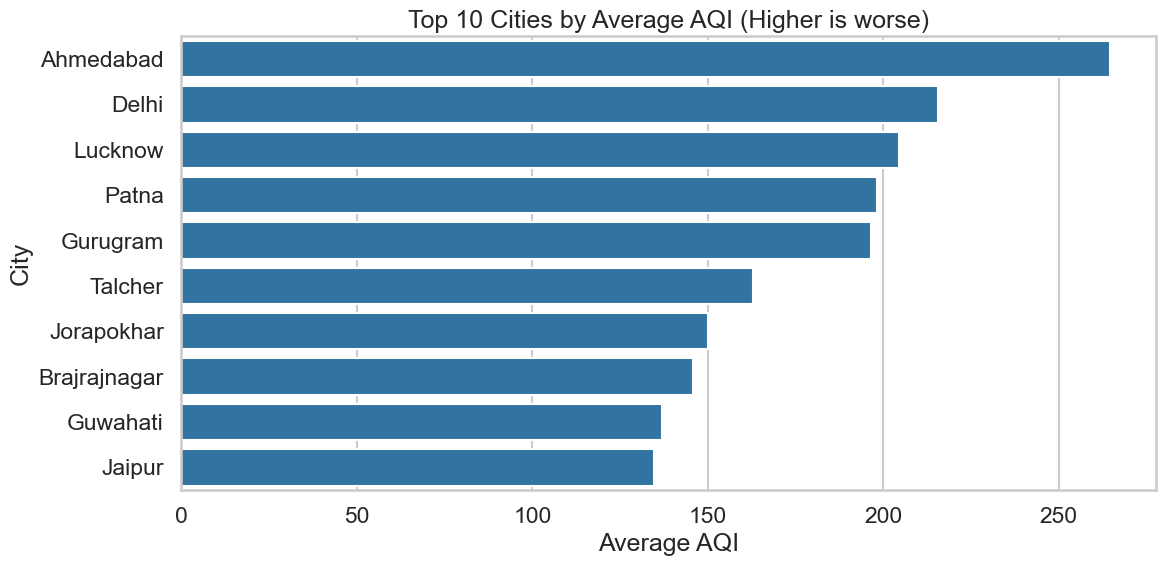

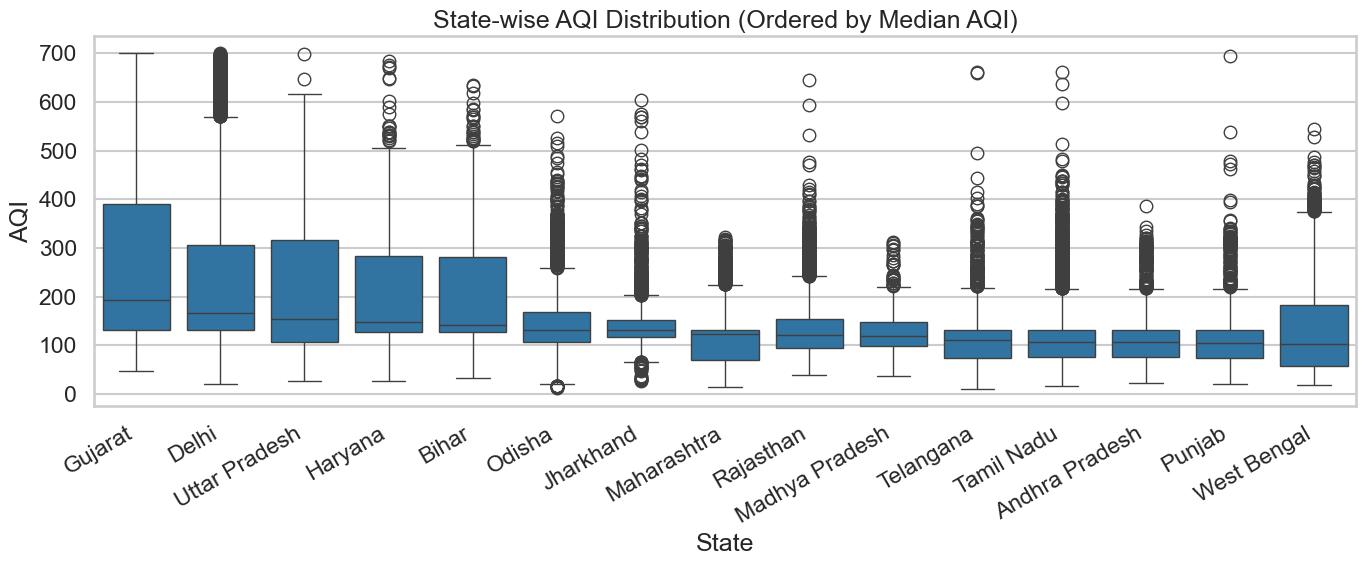

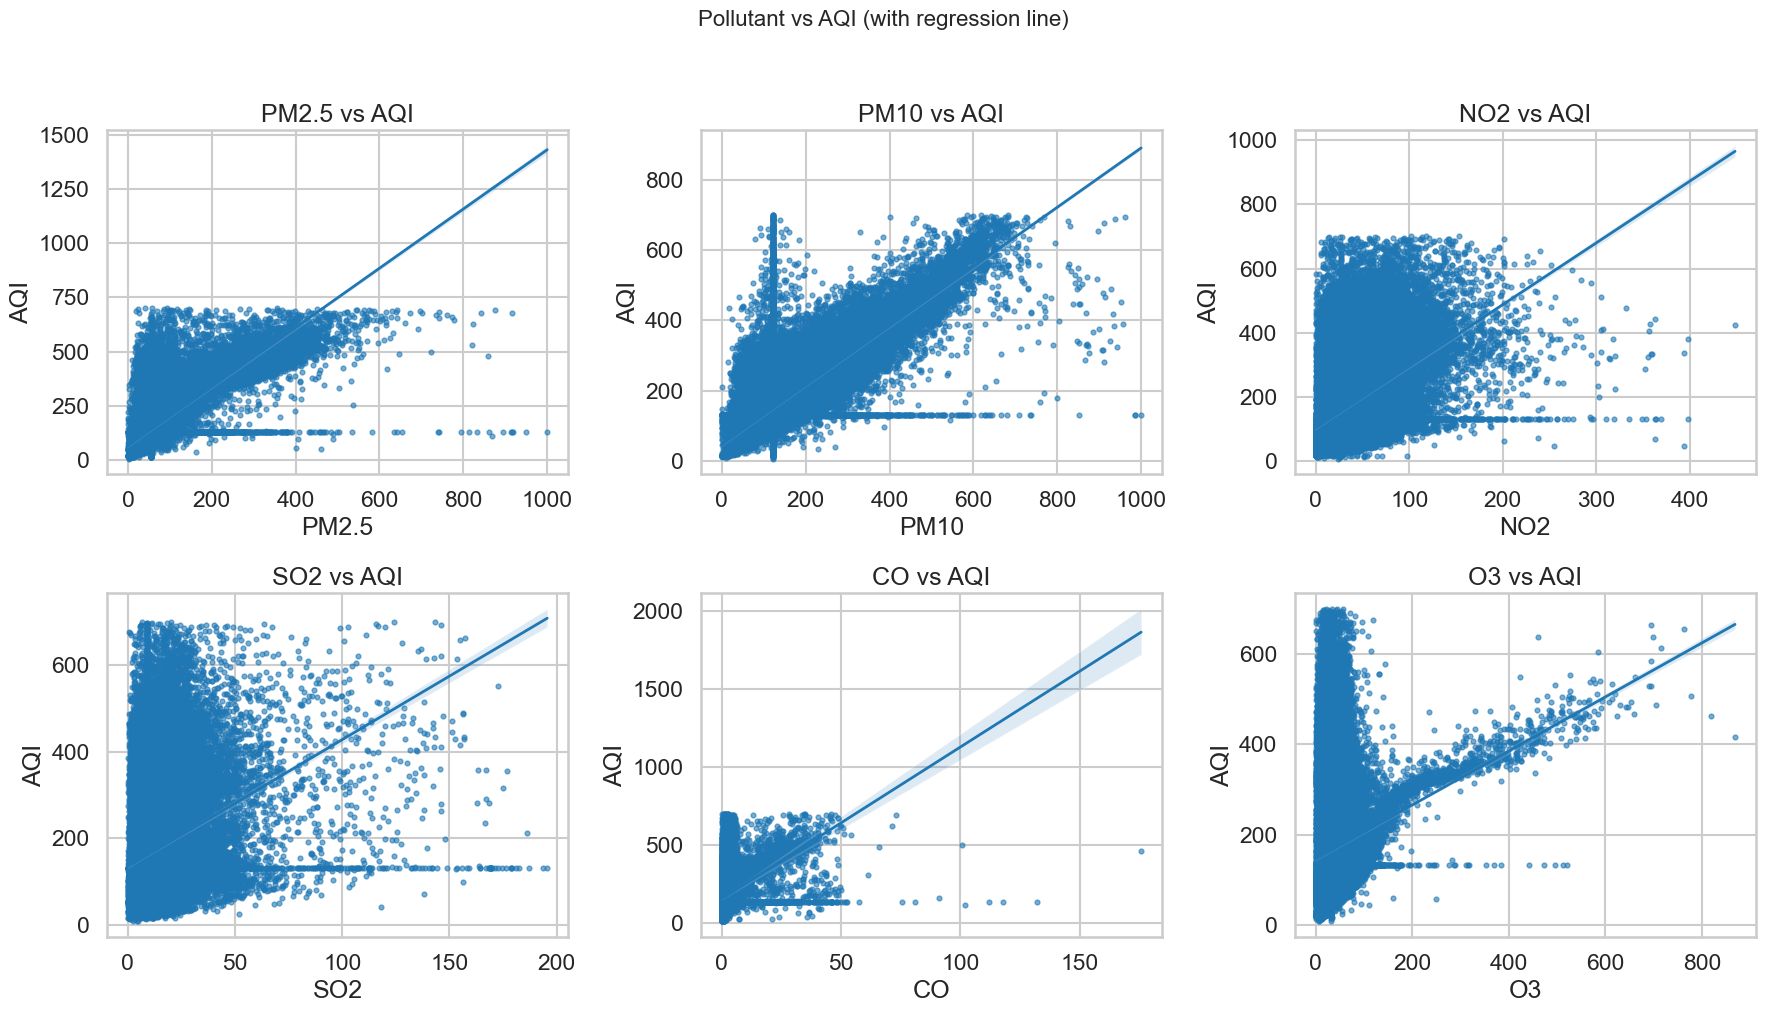

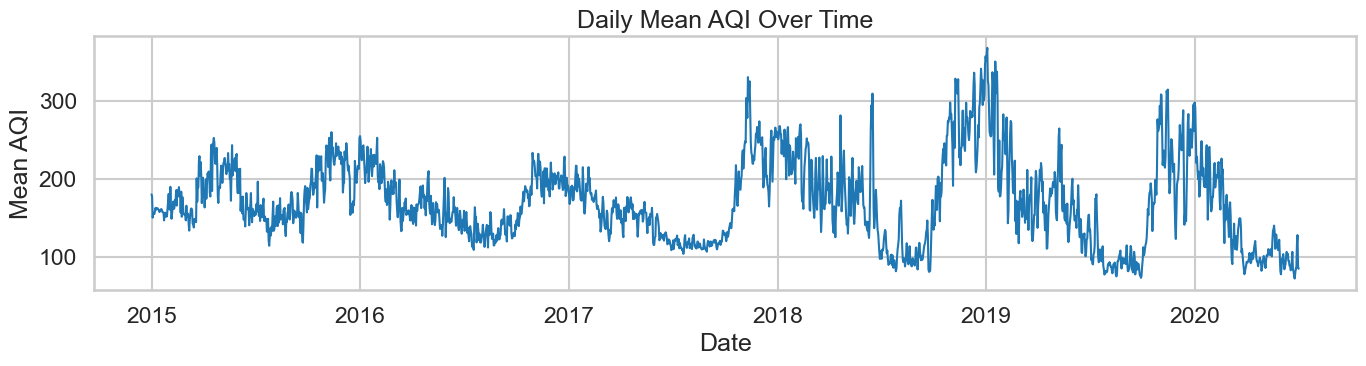

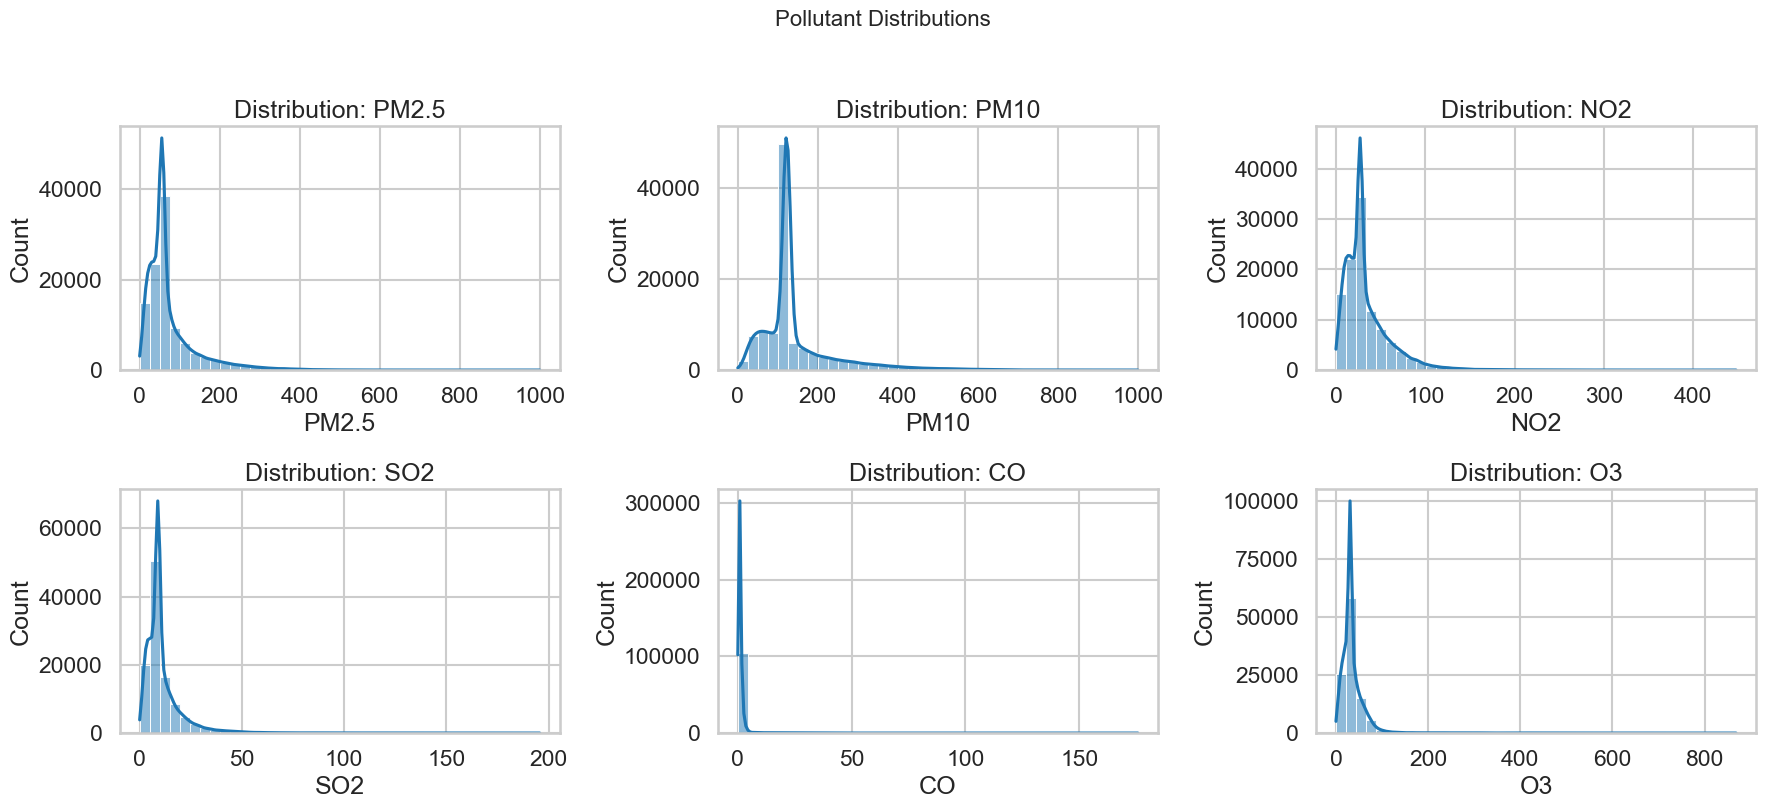

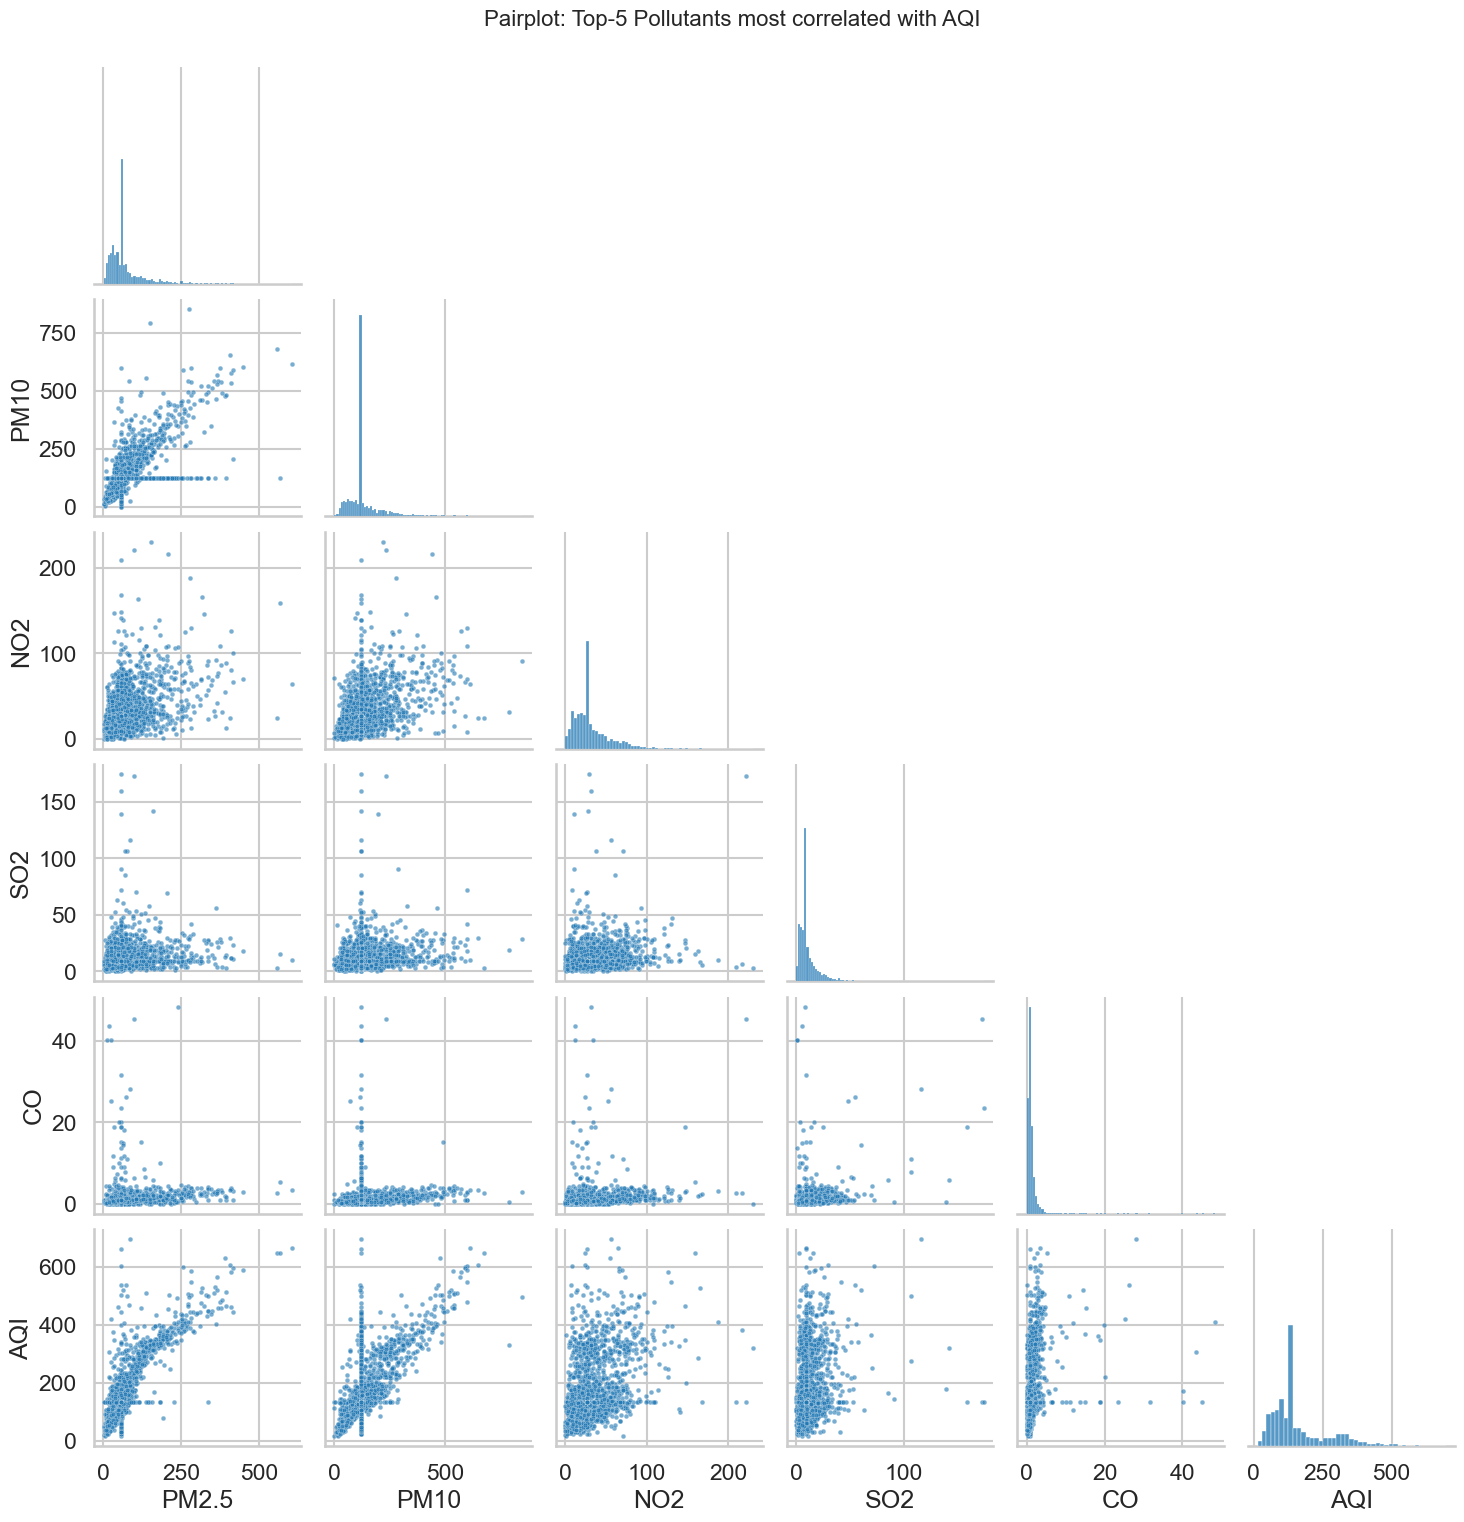

Advanced visualization complete.


In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")


required_cols = set(['AQI', 'City', 'State', 'Date']) | set(numeric_features)
missing = [c for c in required_cols if c not in df.columns]
if missing:
    print("Missing columns in df:", missing)


if {'City','AQI'}.issubset(df.columns):
    city_order = (
        df[['City','AQI']].dropna()
          .groupby('City', as_index=False)['AQI']
          .mean()
          .sort_values('AQI', ascending=False)
          .head(10)
    )
    plt.figure(figsize=(12, 6))
    sns.barplot(data=city_order, x='AQI', y='City', orient='h')
    plt.title("Top 10 Cities by Average AQI (Higher is worse)")
    plt.xlabel("Average AQI")
    plt.ylabel("City")
    plt.tight_layout()
    plt.show()
else:
    print("Skipped city bar chart: City/AQI missing.")

if {'State','AQI'}.issubset(df.columns):
    state_order = (
        df[['State','AQI']].dropna()
          .groupby('State')['AQI']
          .median()
          .sort_values(ascending=False)
          .index
          .tolist()
    )
    top_states = state_order[:15]
    plt.figure(figsize=(14, 6))
    sns.boxplot(
        data=df[df['State'].isin(top_states)],
        x='State', y='AQI',
        order=top_states
    )
    plt.title("State-wise AQI Distribution (Ordered by Median AQI)")
    plt.xlabel("State")
    plt.ylabel("AQI")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Skipped state boxplot: State/AQI missing.")

polls_available = [c for c in numeric_features if c in df.columns]
if 'AQI' in df.columns and len(polls_available) > 0:
    rows, cols = 2, 3
    plt.figure(figsize=(18, 10))
    for i, col in enumerate(polls_available[:rows*cols], start=1):
        ax = plt.subplot(rows, cols, i)
        sns.regplot(
            data=df[[col, 'AQI']].dropna(),
            x=col, y='AQI', scatter_kws={'s':12, 'alpha':0.6}, line_kws={'linewidth':2}
        )
        ax.set_title(f"{col} vs AQI")
    plt.suptitle("Pollutant vs AQI (with regression line)", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("Skipped pollutant vs AQI scatter grid: missing columns.")

if {'Date','AQI'}.issubset(df.columns):
    daily = (
        df[['Date','AQI']].dropna()
          .sort_values('Date')
          .groupby('Date', as_index=True)['AQI']
          .mean()
    )
    plt.figure(figsize=(14, 4))
    plt.plot(daily.index, daily.values, linewidth=1.5)
    plt.title("Daily Mean AQI Over Time")
    plt.xlabel("Date")
    plt.ylabel("Mean AQI")
    plt.tight_layout()
    plt.show()
else:
    print("Skipped AQI time series: Date/AQI missing.")

if len(polls_available) > 0:
    rows, cols = 2, 3
    plt.figure(figsize=(18, 8))
    for i, col in enumerate(polls_available[:rows*cols], start=1):
        ax = plt.subplot(rows, cols, i)
        sns.histplot(df[col].dropna(), kde=True, bins=40, ax=ax)
        ax.set_title(f"Distribution: {col}")
        ax.set_xlabel(col)
    plt.suptitle("Pollutant Distributions", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("Skipped pollutant distributions: no pollutant columns present.")

if 'AQI' in df.columns and len(polls_available) >= 2:
    corr_targets = (
        df[polls_available + ['AQI']]
          .corr(numeric_only=True)['AQI']
          .drop('AQI')
          .abs()
          .sort_values(ascending=False)
    )
    top5 = corr_targets.index[:5].tolist()
    pair_cols = top5 + ['AQI']
    sample_pp = df[pair_cols].dropna()
    if len(sample_pp) > 2000:
        sample_pp = sample_pp.sample(2000, random_state=42)

    if len(sample_pp) >= 50:
        g = sns.pairplot(sample_pp, corner=True, plot_kws={'s': 12, 'alpha': 0.6})
        g.fig.suptitle("Pairplot: Top-5 Pollutants most correlated with AQI", y=1.02, fontsize=16)
        plt.show()
    else:
        print("Skipped pairplot: not enough data after cleaning.")
else:
    print("Skipped pairplot: missing AQI or pollutant columns.")

print("Advanced visualization complete.")


In [33]:
import joblib, os
os.makedirs("models", exist_ok=True)
joblib.dump(vote_pipe, "models/vote_model.joblib")
print("Saved models/vote_model.joblib")


Saved models/vote_model.joblib


In [ ]:


import pandas as pd

print("\nAQI Prediction Interface Ready")

expected_features = numeric_features + categorical_features
print(f"Required input columns ({len(expected_features)}):\n{expected_features}\n")


sample_input = {
    'PM2.5': 85,
    'PM10': 120,
    'NO': 18,
    'NO2': 40,
    'NOx': 52,
    'NH3': 12,
    'CO': 0.9,
    'SO2': 17,
    'O3': 28,
    'City': 'Delhi',
    'State': 'Delhi'
}

df_input = pd.DataFrame([sample_input])[expected_features]
prediction = vote_pipe.predict(df_input)[0]
print(f"\nPredicted AQI: {prediction:.2f}")




AQI Prediction Interface Ready
Required input columns (8):
['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'City', 'State']


Predicted AQI: 183.86
